<a href="https://colab.research.google.com/github/smannan/LIFXBulbAnalysis/blob/main/SmartBulbARIMAModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
!pip3 install statsmodels --upgrade

In [32]:
!pip3 install pmdarima

     |████████████████████████████████| 1.4 MB 8.5 MB/s 


In [19]:
import pandas as pd

from sklearn.metrics import mean_squared_error
from math import sqrt

In [20]:
filename = '/content/drive/Shared drives/CMPE295B/JoinedPGEBulbData/2021-08-26_13_2021-09-26_22_hourly.csv'
bulb_data = pd.read_csv(filename, infer_datetime_format = True).drop(['Unnamed: 0'], axis=1, inplace=False)
bulb_data['timestamp'] = pd.to_datetime(bulb_data['timestamp'])

In [21]:
bulb_data.head()

,index,timestamp,brightness,kelvin,kWH,cost,usage,percent_usage_by_bulb,cost_per_bulb
0,0,2021-08-26 13:00:00,1.0,2700.0,0.0085,0.09,0.35,2.428571,0.002186
1,1,2021-08-26 14:00:00,1.0,2700.0,0.0085,0.11,0.38,2.236842,0.002461
2,2,2021-08-26 15:00:00,1.0,2700.0,0.0085,0.09,0.34,2.500000,0.002250
3,3,2021-08-26 16:00:00,1.0,2700.0,0.0085,0.08,0.29,2.931034,0.002345
4,4,2021-08-26 17:00:00,1.0,2700.0,0.0085,0.11,0.40,2.125000,0.002338


### Visualize time series data

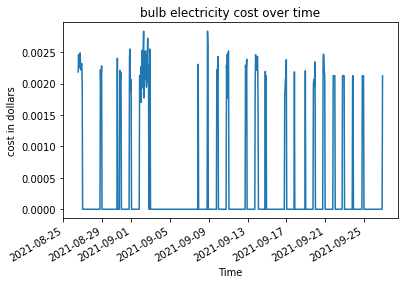

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.plot(bulb_data['timestamp'], bulb_data['cost_per_bulb'])
plt.gcf().autofmt_xdate()
plt.title('bulb electricity cost over time')
plt.ylabel('cost in dollars')
plt.xlabel('Time')
plt.show()

### View autocorrelation plot
- How correlated are current timesteps to previous ones

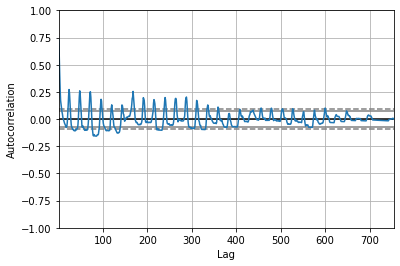

In [23]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(bulb_data[['cost_per_bulb']])
plt.show()

- Looks like there is not a lot of correlation between timesteps?
- Confidence interval = 95% so focus on correlations within this interval as they are likely not statistical flukes


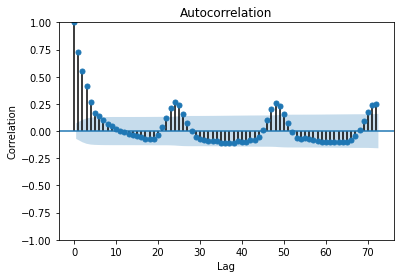

In [24]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(bulb_data[['cost_per_bulb']], lags=72)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

- Data does not visually look stationary and may even exhibit seasonality
- Augmented Dickey-Fuller Test? - determines a differencing order is needed

In [35]:
from pmdarima.arima import ADFTest
ADFTest(alpha = 0.05).should_diff(train)

(0.01, False)

### View partial autocorrelation
- Removes indirect relationships between lags

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


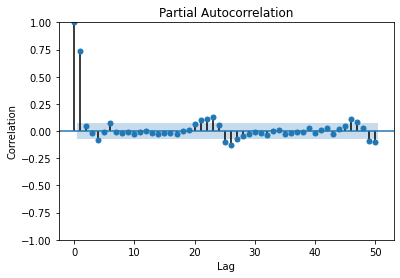

In [25]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(bulb_data[['cost_per_bulb']], lags=50)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

### Summary
- ACF correlation should be strong for the first k lags then taper off
- PACF should have *no* correlation after k
- Want data to be stationary - remove any trends beforehand analysis
- Ex correlation plots: https://www.itl.nist.gov/div898/handbook/eda/section3/autocopl.htm

In [49]:
def split_train_test(bulb_data, split):
  arima_df = bulb_data[['timestamp', 'cost_per_bulb']]
  arima_df.set_index('timestamp', drop=True, inplace=True)
  values = arima_df.values
  size = int(len(values) * split)
  train = values[:size]
  test = values[size:]
  return (train, test)

In [50]:
train, test = split_train_test(bulb_data[['timestamp', 'cost_per_bulb']], 0.8)
print (len(train), len(test))

603 151


### Model parameters

- p = number of lagged observations to use - how many previous time steps will affect the current one?

- d = differencing factor, how many previous timesteps to subtract from the current one to make the series stationary? most non-seasonal models will not go higher than 2 in practice to avoid over-differencing

- q = moving average window - adjusts averages based on current errors to make the model better, assumes there is some autocorrelation in the residuals

In [54]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

def fit_model(train):
  model = ARIMA(train, order=(10, 1, 0))
  model_fit = model.fit()

  residuals = pd.DataFrame(model_fit.resid)
  residuals.plot()
  residuals.plot(kind='kde')

  return model_fit, residuals

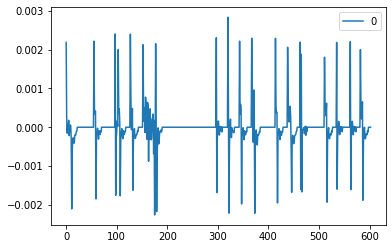

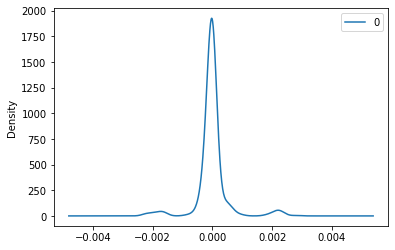

In [29]:
model_fit, residuals = fit_model(train)

### Residuals from the model don't have significant autocorrelations - may not need a moving average window

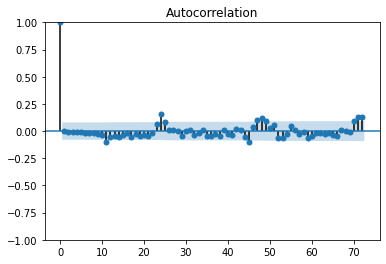

In [30]:
plot_acf(residuals, lags=72)
plt.show()

In [64]:
def rolling_predictions(train, test, order=(10, 1, 0), auto=False):
  # put training points in a list
  history = [x for x in train]
  # for storing predictions
  predictions = list()

  # walk-forward validation
  for t in range(len(test)):
    # fit new model each iteration based on all past data points
    # get the next datapoint and add it to predictions
    if (auto):
      model = auto_arima(history)
      output = auto_arima_model.predict(n_periods=1)[0]
    else:
      model = ARIMA(history, order=order).fit()
      output = model_fit.forecast()[0]
    
    predictions.append(output)
    history.append(test[t])

  rmse = sqrt(mean_squared_error(test, predictions))
  return (predictions, rmse)

In [ ]:
predictions, rmse = rolling_predictions(train, test)

In [57]:
def plot_preds(test, predictions):
  plt.title('Hourly lighting cost predictions')
  plt.xlabel('Timestep')
  plt.ylabel('Cost in Dollars')
  plt.plot(test)
  plt.plot(predictions, color='red')
  plt.show()

In [55]:
auto_arima_model = auto_arima(train)
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  603
Model:               SARIMAX(2, 0, 0)   Log Likelihood                3690.334
Date:                Sun, 10 Oct 2021   AIC                          -7372.668
Time:                        19:57:46   BIC                          -7355.060
Sample:                             0   HQIC                         -7365.815
                                - 603                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.447e-05   7.71e-05      0.966      0.334   -7.66e-05       0.000
ar.L1          0.6703      0.053     12.627      0.000       0.566       0.774
ar.L2          0.0887      0.028      3.195      0.001       0.034       0.143
sigma2      2.799e-07   1.91e-08     14.684      0.000    2.43e-07    3.17e-07
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              2449.16
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             1.15
Prob(H) (two-sided):                  0.54   Kurtosis:                        12.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
predictions, rmse = rolling_predictions(train, test, auto=True)

KeyboardInterrupt: ignored